# Исследование данных о пользователях сервиса аренды самокатов

Получены данные о некоторых пользователях популярного сервиса аренды самокатов  из нескольких городов, а также об их поездках. 

**Задача** - Нужно проанализировать данные и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти.
Чтобы совершать поездки по городу, пользователи сервиса пользуются мобильным приложением.

Сервисом можно пользоваться:

- **без подписки:**
- абонентская плата отсутствует;
- стоимость одной минуты поездки — 8 рублей;
- стоимость старта (начала поездки) — 50 рублей;

- **с подпиской Ultra:**
- абонентская плата — 199 рублей в месяц;
- стоимость одной минуты поездки — 6 рублей;
- стоимость старта — бесплатно.

- **Пользователи — users_go**
- user_id- уникальный идентификатор пользователя
- name	- имя пользователя
- age	- возраст
- city	- город
- subscription_type	- тип подписки (free, ultra)

- **Поездки — rides_go**
- user_id	- уникальный идентификатор пользователя
- distance	- расстояние, которое пользователь проехал в текущей сессии (в метрах)
- duration	- продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
- date	- дата совершения поездки

- **Подписки — subscriptions_go**
- subscription_type	- тип подписки
- minute_price	- стоимость одной минуты поездки по данной подписке
- start_ride_price	- стоимость начала поездки
- subscription_fee	- стоимость ежемесячного платежа

In [1]:
#используемые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import binom, norm
from math import sqrt

## Загрузка и предварительное исследование данных 

### Загрузка данных

Для начала загрузим данные 3-х датафреймов, которые содержат информацию о пользователях, их поездках и подписках.

In [3]:
#Посмотрим на полученный датафрейм
users.head(10)

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
5,6,Регина,25,Краснодар,ultra
6,7,Игорь,23,Омск,ultra
7,8,Юрий,23,Краснодар,ultra
8,9,Ян,21,Пятигорск,ultra
9,10,Валерий,18,Екатеринбург,ultra


In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


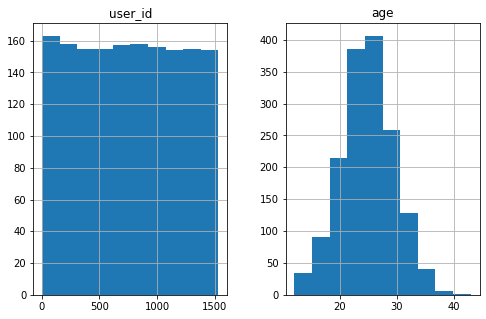

In [5]:
#Построим гистограммы
users.hist(figsize=(8,5));

In [7]:
#Посмотрим на полученный датафрейм
rides.head(10)

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
5,1,2770.890808,16.650138,2021-10-09
6,1,3039.020292,14.927879,2021-10-19
7,1,2842.118050,23.117468,2021-11-06
8,1,3412.690668,15.238072,2021-11-14
9,1,748.690645,15.041884,2021-11-22


In [8]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


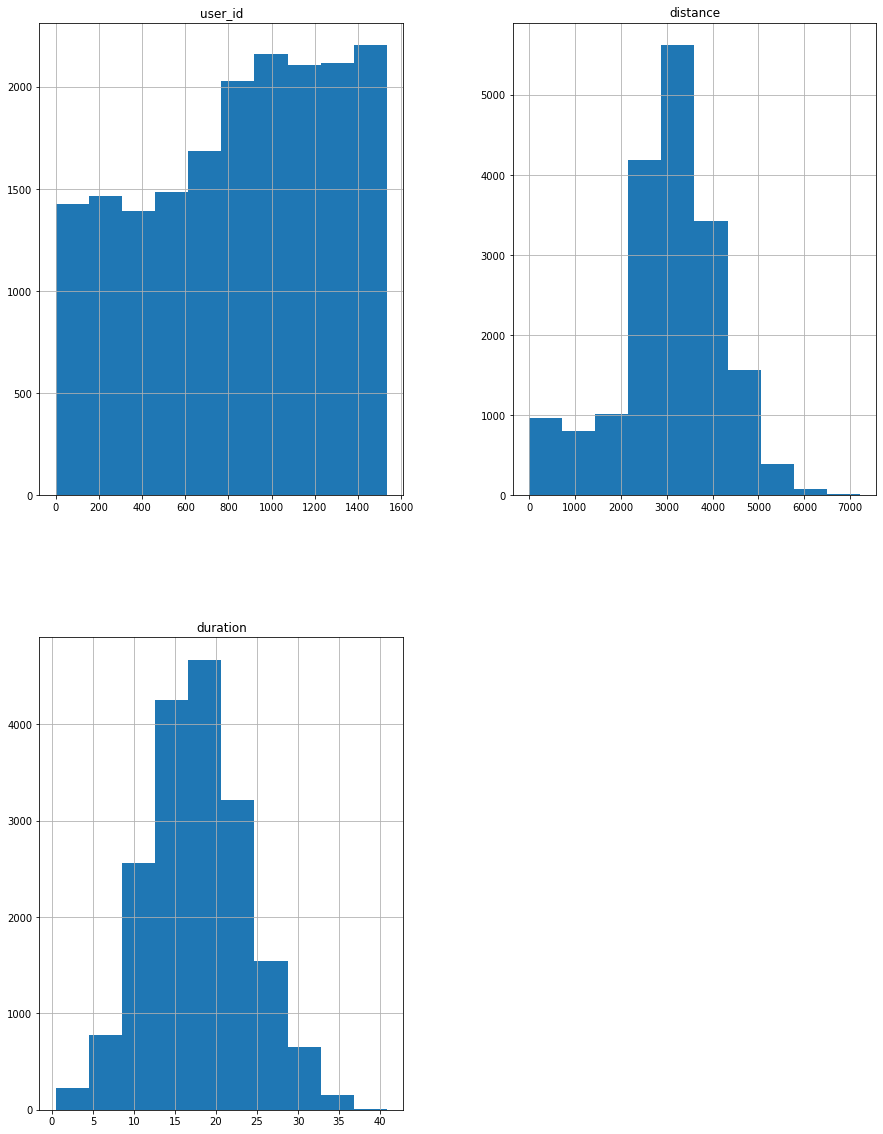

In [9]:
#Построим гистограммы
rides.hist(figsize=(15, 20));

In [11]:
#Посмотрим на полученный датафрейм
subscriptions

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


**Вывод:** 
На основе предоставленной информации, данные DataFrame выглядят вполне структурированными и без явных проблем. Однако, рассмотрим некоторые аспекты, которые могут потребовать внимания при обработке данных: типы данных в столбцах "user_id" и "age" соответствуют ожидаемым (целочисленные значения). Тип данных в столбцах "name", "city" и "subscription_type" также соответствует ожидаемым строковым значениям (object). Однако, нужно будет столбец "date" привести к формату datetime. 
Все столбцы содержат 18068 (rides), 1565 (users) и 2(subscriptions) непустых значений, что означает отсутствие пропущенных значений в данных.
Для некоторых столбцов, таких как "subscription_type", возможно имеет смысл оценить уникальные значения, чтобы убедиться в разнообразии данных и отсутствии неожиданных категорий.
Возможно, имеет смысл проверить наличие статистических аномалий, таких как выбросы в столбце "age", "distance" и "duration"
Общее впечатление от данных — они кажутся чистыми и подготовленными для анализа..

### Предобработка данных

Теперь приступим к обработке полученных датафреймов и подготовке их к анализу

In [12]:
# приведем first_day_exposition к объекту datetime используя pd.to_datetime()
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d')

In [13]:
#Посмотрим на полученный датафрейм
rides.head(10)

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
5,1,2770.890808,16.650138,2021-10-09
6,1,3039.020292,14.927879,2021-10-19
7,1,2842.118050,23.117468,2021-11-06
8,1,3412.690668,15.238072,2021-11-14
9,1,748.690645,15.041884,2021-11-22


In [14]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


In [15]:
#добавим столбец с номером месяца
rides['month'] = rides['date'].dt.month

In [16]:
#Посмотрим на полученный датафрейм
rides.head(10)

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8
5,1,2770.890808,16.650138,2021-10-09,10
6,1,3039.020292,14.927879,2021-10-19,10
7,1,2842.118050,23.117468,2021-11-06,11
8,1,3412.690668,15.238072,2021-11-14,11
9,1,748.690645,15.041884,2021-11-22,11


In [17]:
#в "subscription_type", возможно имеет смысл оценить уникальные значения
users['subscription_type'].unique()

array(['ultra', 'free'], dtype=object)

В subscription_type все впорядке, найдено 2 уникальных значения: 'ultra', 'free'

In [18]:
users.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
1560     True
1561     True
1562     True
1563     True
1564     True
Length: 1565, dtype: bool

Этот вывод показывает логический ряд из булевых значений, где каждое значение указывает, является ли соответствующая строка в датафрейме пользователей (users) дубликатом (True) или нет (False). Когда значение True, это означает, что данная строка полностью совпадает с предыдущей строкой в датафрейме.

In [19]:
# посмотрим на количество дубликатов
users.duplicated().sum()

31

In [20]:
duplicated_users = users[users.duplicated()]

In [21]:
duplicated_users

,user_id,name,age,city,subscription_type
1534,293,Агата,26,Краснодар,ultra
1535,16,Амалия,27,Краснодар,ultra
1536,909,Константин,20,Екатеринбург,free
1537,403,Полина,19,Сочи,ultra
1538,908,Рустам,30,Тюмень,free
1539,43,Стефания,22,Омск,ultra
1540,127,Павел,25,Пятигорск,ultra
1541,659,Злата,27,Ростов-на-Дону,ultra
1542,204,Руслан,30,Пятигорск,ultra
1543,153,Герман,23,Москва,ultra


Эта таблица показывает дубликаты в датафрейме пользователей по столбцу 'user_id'. Дубликаты по 'user_id' могут указывать на наличие нескольких записей для одного и того же пользователя. Такие дубликаты могут возникнуть из-за ошибок в сборе данных или технических аспектов системы.
Чтобы устранить дубликаты, можно использовать метод drop_duplicates

In [22]:
users = users.drop_duplicates(subset=['user_id']).reset_index()

In [23]:
# теперь посмотрим на количество дубликатов
users.duplicated().sum()

0

все дубликаты успешно устранены

In [24]:
#посмотрим на наличие дубликатов в датафрейме rides
rides.duplicated().sum()

0

In [25]:
#в "subscription_type", возможно имеет смысл оценить уникальные значения
users['name'].unique()

array(['Кира', 'Станислав', 'Алексей', 'Константин', 'Адель', 'Регина',
       'Игорь', 'Юрий', 'Ян', 'Валерий', 'Агата', 'Марк', 'Ева',
       'Антонина', 'Валерия', 'Амалия', 'Даниил', 'Аделина', 'Святогор',
       'Борис', 'Вероника', 'Ростислав', 'Назар', 'Эдуард', 'Василий',
       'Денис', 'Тамара', 'Николай', 'Эвелина', 'Федор', 'Руслан', 'Иван',
       'Любовь', 'Ярослава', 'Майя', 'Ильдар', 'Данила', 'Нина',
       'Стефания', 'Ясмина', 'Дмитрий', 'Александр', 'Одиссей', 'Арсений',
       'Алла', 'Таисия', 'Максим', 'Юлиана', 'Павел', 'Карина', 'Алиса',
       'Лидия', 'Рамиль', 'Родион', 'Ника', 'Оксана', 'Анастасия',
       'Маргарита', 'Вера', 'Тимур', 'Никита', 'Лев', 'Влад', 'Артур',
       'Анна', 'Ольга', 'Вячеслав', 'Ксения', 'Виталина', 'Владислав',
       'Тамерлан', 'Амина', 'Вадим', 'Олеся', 'Зарина', 'Егор', 'Гордей',
       'Лилия', 'Святослав', 'Роберт', 'Амир', 'Влада', 'Богдан',
       'Полина', 'Марат', 'Елисей', 'Макар', 'Алина', 'Глеб', 'Андрей',
       'Ал

In [26]:
users['name'].value_counts()

Анна         22
Мария        22
Дмитрий      17
Александр    17
Никита       16
             ..
Алина         3
Семен         2
Тихон         1
Милана        1
Радмир        1
Name: name, Length: 194, dtype: int64

In [27]:
users['city'].unique()

array(['Тюмень', 'Омск', 'Москва', 'Ростов-на-Дону', 'Краснодар',
       'Пятигорск', 'Екатеринбург', 'Сочи'], dtype=object)

с данными все в порядке, неявных дубликатов не обнаружено

In [28]:
#Посмотрим на самых младших пользователей
users.query('age<15')

,index,user_id,name,age,city,subscription_type
20,20,21,Святогор,14,Ростов-на-Дону,ultra
34,34,35,Руслан,12,Пятигорск,ultra
66,66,67,Анастасия,12,Ростов-на-Дону,ultra
83,83,84,Анна,13,Екатеринбург,ultra
145,145,146,Ева,14,Ростов-на-Дону,ultra
235,235,236,Владимир,13,Тюмень,ultra
314,314,315,Игорь,13,Москва,ultra
448,448,449,Александр,14,Москва,ultra
553,553,554,Евгений,13,Тюмень,ultra
664,664,665,Герман,12,Сочи,ultra


In [29]:
#Посмотрим на самых старших пользователей
users.query('age>40')

,index,user_id,name,age,city,subscription_type
1201,1201,1202,Ангелина,43,Москва,free


**Вывод:**

В ходе выполнения предварительной обработки, столбец "date" был приведен к формату datetime и добавили новый столбец с номером месяца. Также были обнаружены и удалены дубликаты в датафрейме rides

## Исследовательский анализ данных

Далее опишем и визуализируем общую информацию о пользователях и поездках

### Частота встречаемости городов

In [30]:
#посмотрим на частоту встречаемости городов
city_distribution = users['city'].value_counts()

In [31]:
city_distribution

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

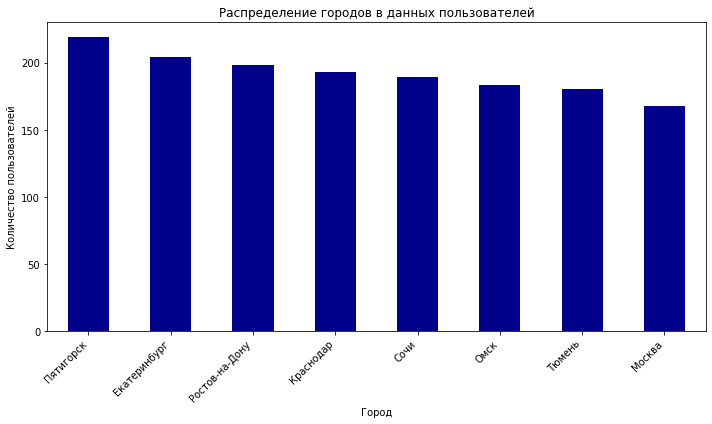

In [32]:
# Построим график для визуализации полученных данных
plt.figure(figsize=(10, 6))
city_distribution.plot(kind='bar', color='darkblue')
plt.title('Распределение городов в данных пользователей')
plt.xlabel('Город')
plt.ylabel('Количество пользователей')
plt.xticks(rotation=45, ha='right')  
plt.tight_layout()

plt.show()

 Согласно полученным данным, в топ городов-пользователей сервиса аренды самокатов вошли Пятигорск (226 пользователей),
Екатеринбург (206 пользователей) и Ростов-на-Дону (202 пользователя). Но разница между 1-ым и последним местом (Москва) всего 54 человека.

### Соотношение пользователей с подпиской и без подписки

In [33]:
# Объединим данные о пользователях с данными о подписках
merged_data = pd.merge(users, subscriptions, on='subscription_type', how='left')

In [34]:
#Посмотрим на полученный датафрейм
merged_data.head(10)

,index,user_id,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,0,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2,Станислав,31,Омск,ultra,6,0,199
2,2,3,Алексей,20,Москва,ultra,6,0,199
3,3,4,Константин,26,Ростов-на-Дону,ultra,6,0,199
4,4,5,Адель,28,Омск,ultra,6,0,199
5,5,6,Регина,25,Краснодар,ultra,6,0,199
6,6,7,Игорь,23,Омск,ultra,6,0,199
7,7,8,Юрий,23,Краснодар,ultra,6,0,199
8,8,9,Ян,21,Пятигорск,ultra,6,0,199
9,9,10,Валерий,18,Екатеринбург,ultra,6,0,199


In [35]:
#Подсчитаем количество пользователей с подпиской и без подписки
subscription_counts = merged_data['subscription_type'].value_counts()

In [36]:
subscription_counts 

free     835
ultra    699
Name: subscription_type, dtype: int64

In [37]:
# Рассчитаем соотношения пользователей с подпиской и без подписки
subscription_ratio = subscription_counts / len(users)

In [38]:
subscription_ratio

free     0.544329
ultra    0.455671
Name: subscription_type, dtype: float64

Предоставленные результаты отражают соотношение пользователей с различными типами подписок в сервисе аренды самокатов GoFast. В данном случае, данные описывают долю пользователей с подпиской "ultra" и без подписки "free". Представленные числа отражают процентное соотношение каждой из подписок относительно общего числа пользователей. Пользователи с подпиской "free": Примерно 54.06% от общего числа пользователей сервиса GoFast не используют абонентскую подписку и, вероятно, платят за каждую поездку отдельно.Пользователи с подпиской "ultra": Примерно 45.94% от общего числа пользователей выбирают подписку "ultra", что предоставляет им привилегии, такие как бесплатный старт поездки и более низкая стоимость за минуту поездки.
Возможно, следует провести дополнительные маркетинговые кампании для привлечения пользователей к типу подписки ultra или адаптировать условия подписки, чтобы сделать ее более привлекательной для широкого круга пользователей.

### Возраст пользователей

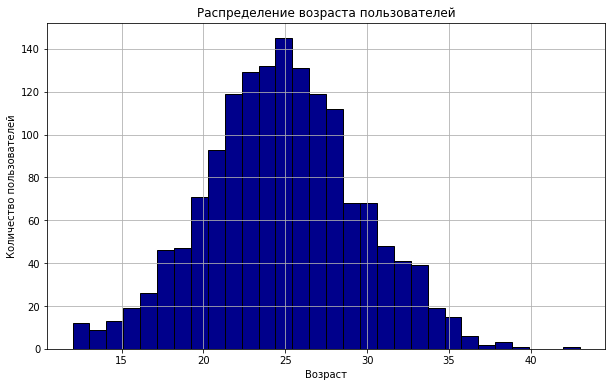

In [39]:
#Построим гистограмму по возрасту пользователей
plt.figure(figsize=(10, 6))
users['age'].hist(bins=30, color='darkblue', edgecolor='black')

# Добавим подписи осей и заголовка
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей')
plt.title('Распределение возраста пользователей')

plt.show()

In [40]:
users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

Судя по гистограмме, средний возраст пользователя сервиса аренды самокатов GoFast - 25 лет, пользователей с возрастом более 40 лет редко встретишь. Молодые люди, такие как студенты или молодые работники, могут чаще иметь потребность в быстром и удобном транспортном средстве для перемещения по городу. Молодые люди могут быть более открытыми для использования аренды самокатов из-за экономических соображений или потребности в бюджетных вариантах транспорта. Можно отметить наличие пользователей даже младше 18 лет.

In [41]:
# посмотрим на количество пользователей меньше 18 лет
users.query('age<18')

,index,user_id,name,age,city,subscription_type
20,20,21,Святогор,14,Ростов-на-Дону,ultra
33,33,34,Федор,17,Краснодар,ultra
34,34,35,Руслан,12,Пятигорск,ultra
48,48,49,Одиссей,17,Ростов-на-Дону,ultra
66,66,67,Анастасия,12,Ростов-на-Дону,ultra
...,...,...,...,...,...,...
1474,1474,1475,Артём,17,Тюмень,free
1475,1475,1476,Стефания,13,Москва,free
1476,1476,1477,Ян,17,Сочи,free
1487,1487,1488,Рамиль,15,Екатеринбург,free


79 пользователей - младше 18 лет

###  Расстояние, которое пользователь преодолел за одну поездку

In [42]:
#Пересчитаем расстояния для каждой поездки в километрах
rides['distance_km'] = rides['distance'] / 1000

In [43]:
#Посмотрим на полученный датафрейм
rides.head(10)

,user_id,distance,duration,date,month,distance_km
0,1,4409.919140,25.599769,2021-01-01,1,4.409919
1,1,2617.592153,15.816871,2021-01-18,1,2.617592
2,1,754.159807,6.232113,2021-04-20,4,0.754160
3,1,2694.783254,18.511000,2021-08-11,8,2.694783
4,1,4028.687306,26.265803,2021-08-28,8,4.028687
5,1,2770.890808,16.650138,2021-10-09,10,2.770891
6,1,3039.020292,14.927879,2021-10-19,10,3.039020
7,1,2842.118050,23.117468,2021-11-06,11,2.842118
8,1,3412.690668,15.238072,2021-11-14,11,3.412691
9,1,748.690645,15.041884,2021-11-22,11,0.748691


In [44]:
#окгруглим столбец до 2 знаков после запятой
rides['distance_km'] = rides['distance_km'].round(2)

In [45]:
#Посмотрим на полученный датафрейм
rides.head(10)

,user_id,distance,duration,date,month,distance_km
0,1,4409.919140,25.599769,2021-01-01,1,4.41
1,1,2617.592153,15.816871,2021-01-18,1,2.62
2,1,754.159807,6.232113,2021-04-20,4,0.75
3,1,2694.783254,18.511000,2021-08-11,8,2.69
4,1,4028.687306,26.265803,2021-08-28,8,4.03
5,1,2770.890808,16.650138,2021-10-09,10,2.77
6,1,3039.020292,14.927879,2021-10-19,10,3.04
7,1,2842.118050,23.117468,2021-11-06,11,2.84
8,1,3412.690668,15.238072,2021-11-14,11,3.41
9,1,748.690645,15.041884,2021-11-22,11,0.75


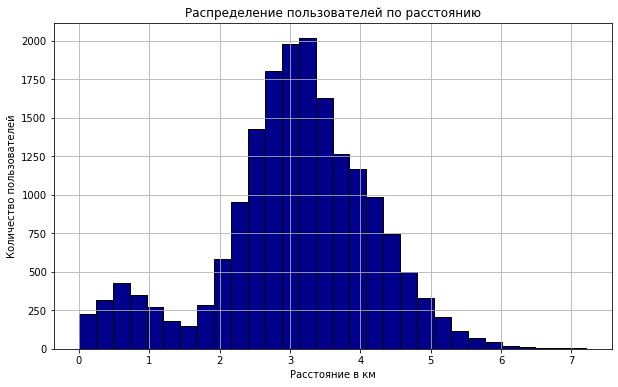

In [46]:
#Построим гистограмму по расстоянию, которое пользователь преодолел за одну поездку
plt.figure(figsize=(10, 6))
rides['distance_km'].hist(bins=30, color='darkblue', edgecolor='black')

# Добавим подписи осей и заголовка
plt.xlabel('Расстояние в км')
plt.ylabel('Количество пользователей')
plt.title('Распределение пользователей по расстоянию')

plt.show()

In [47]:
rides['distance_km'].describe()

count    18068.000000
mean         3.070649
std          1.116847
min          0.000000
25%          2.540000
50%          3.130000
75%          3.780000
max          7.210000
Name: distance_km, dtype: float64

Судя по полученным данным, 2-3 км - среднее расстояние, которое преодолевает пользователь. Пользователи редко преодолевают более 6 км. Что касается двух пиков на гистограмме (0.6 и 3 км), это может свидетельствовать о наличии двух различных групп пользователей с характерными для них расстояниями поездок. Второй, меньший пик в более низком диапазоне может указывать на отдельную группу пользователей, которые часто совершают более короткие поездки, возможно, для краткосрочных перемещений в пределах одного района или для частых коротких поездок.

### Продолжительность поездок

In [48]:
#окгруглим столбец до 2 знаков после запятой
rides['duration'] = rides['duration'].round(2)

In [49]:
#Посмотрим на полученный датафрейм
rides.head(10)

,user_id,distance,duration,date,month,distance_km
0,1,4409.919140,25.60,2021-01-01,1,4.41
1,1,2617.592153,15.82,2021-01-18,1,2.62
2,1,754.159807,6.23,2021-04-20,4,0.75
3,1,2694.783254,18.51,2021-08-11,8,2.69
4,1,4028.687306,26.27,2021-08-28,8,4.03
5,1,2770.890808,16.65,2021-10-09,10,2.77
6,1,3039.020292,14.93,2021-10-19,10,3.04
7,1,2842.118050,23.12,2021-11-06,11,2.84
8,1,3412.690668,15.24,2021-11-14,11,3.41
9,1,748.690645,15.04,2021-11-22,11,0.75


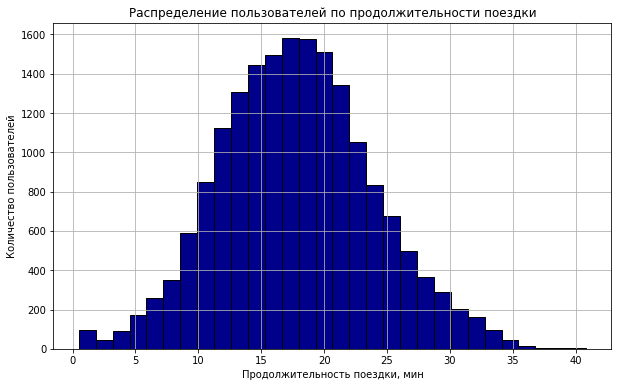

In [50]:
#Построим гистограмму по продолжительности поездок:
plt.figure(figsize=(10, 6))
rides['duration'].hist(bins=30, color='darkblue', edgecolor='black')

# Добавим подписи осей и заголовка
plt.xlabel('Продолжительность поездки, мин')
plt.ylabel('Количество пользователей')
plt.title('Распределение пользователей по продолжительности поездки')

plt.show()
#Построим гистограмму

In [51]:
rides['duration'].describe()

count    18068.000000
mean        17.805017
std          6.091071
min          0.500000
25%         13.600000
50%         17.680000
75%         21.722500
max         40.820000
Name: duration, dtype: float64

Судя по полученным данным, в среднем поездка длится 17 минут и очень редко более 35 минут. Это может свидетельствовать о том, что пользователи склонны использовать самокаты для коротких перемещений в пределах города или на небольшие расстояния.

In [52]:
# Посмотрим на наличие поездок, которые длились меньше минуты
rides.query('duration<1')

,user_id,distance,duration,date,month,distance_km
6531,701,4196.445201,0.5,2021-08-31,8,4.20
6570,704,4830.824371,0.5,2021-10-14,10,4.83
6680,712,4684.004397,0.5,2021-03-04,3,4.68
6695,713,5215.642710,0.5,2021-02-25,2,5.22
6768,718,5197.436649,0.5,2021-02-11,2,5.20
...,...,...,...,...,...,...
17004,1460,5531.335845,0.5,2021-01-19,1,5.53
17242,1477,6724.932981,0.5,2021-01-12,1,6.72
17314,1483,4445.481070,0.5,2021-03-06,3,4.45
17505,1496,5722.551787,0.5,2021-02-14,2,5.72


Таких данных с поезками менее минуты оказалось 95. Поездки с длительностью менее 1 минуты, как видно из наших данных, действительно кажутся аномалиями или, возможно, ошибками в данных. Обычно такие короткие поездки не имеют смысла, так как даже небольшая поездка требует определенного времени на начало и завершение. Поэтому такие даные удалим

In [53]:
rides = rides.query('duration >= 1')

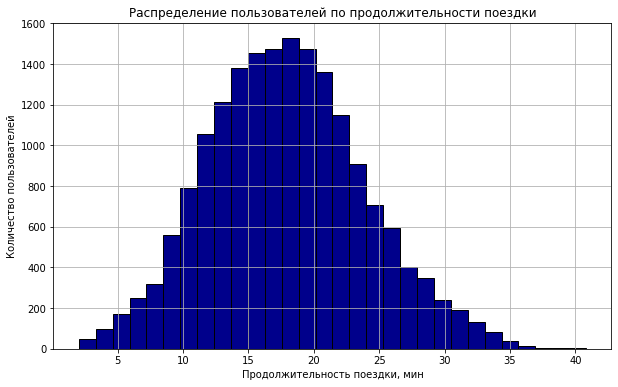

In [54]:
#Построим обновленную гистограмму по продолжительности поездок:
plt.figure(figsize=(10, 6))
rides['duration'].hist(bins=30, color='darkblue', edgecolor='black')

# Добавим подписи осей и заголовка
plt.xlabel('Продолжительность поездки, мин')
plt.ylabel('Количество пользователей')
plt.title('Распределение пользователей по продолжительности поездки')

plt.show()
#Построим гистограмму

### Вывод: 
При анализе данных GoFast выделены топовые города-пользователи, где Пятигорск, Екатеринбург и Ростов-на-Дону, занимающие лидирующие позиции. Однако разница между лидерами и аутсайдером (Москвой) невелика, всего 54 человека.
Относительно подписок, более половины пользователей (54.06%) не используют абонентскую подписку, предпочитая оплату за каждую поездку. В то время как подписка "ultra" выбрана 45.94% пользователей, предоставляя привилегии, такие как бесплатный старт и сниженная стоимость за минуту.
Средний возраст пользователя составляет 25 лет, преобладают молодые люди, что может свидетельствовать о спросе на удобные транспортные средства среди студентов и молодых работников. Данные также указывают на среднюю длительность поездки в 15-20 минут, что свидетельствует о их использовании для коротких перемещений внутри города.

## Объединение данных

###  Объединение данных о пользователях, поездках и подписках в один датафрейм. 

In [55]:
# Объединение данных о пользователях и поездках по user_id
merged2_data = pd.merge(rides, users, on='user_id', how='left')

In [56]:
# Объединение полученного датафрейма с данными о подписках по subscription_type
final_data = pd.merge(merged2_data, subscriptions, on='subscription_type', how='left')

In [57]:
#Посмотрим на полученный датафрейм
final_data.head(15)

,user_id,distance,duration,date,month,distance_km,index,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.60,2021-01-01,1,4.41,0,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.82,2021-01-18,1,2.62,0,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.23,2021-04-20,4,0.75,0,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.51,2021-08-11,8,2.69,0,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.27,2021-08-28,8,4.03,0,Кира,22,Тюмень,ultra,6,0,199
5,1,2770.890808,16.65,2021-10-09,10,2.77,0,Кира,22,Тюмень,ultra,6,0,199
6,1,3039.020292,14.93,2021-10-19,10,3.04,0,Кира,22,Тюмень,ultra,6,0,199
7,1,2842.118050,23.12,2021-11-06,11,2.84,0,Кира,22,Тюмень,ultra,6,0,199
8,1,3412.690668,15.24,2021-11-14,11,3.41,0,Кира,22,Тюмень,ultra,6,0,199
9,1,748.690645,15.04,2021-11-22,11,0.75,0,Кира,22,Тюмень,ultra,6,0,199


In [58]:
#Посмотрим на информацию об объединенном датафрейме
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17973 entries, 0 to 17972
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            17973 non-null  int64         
 1   distance           17973 non-null  float64       
 2   duration           17973 non-null  float64       
 3   date               17973 non-null  datetime64[ns]
 4   month              17973 non-null  int64         
 5   distance_km        17973 non-null  float64       
 6   index              17973 non-null  int64         
 7   name               17973 non-null  object        
 8   age                17973 non-null  int64         
 9   city               17973 non-null  object        
 10  subscription_type  17973 non-null  object        
 11  minute_price       17973 non-null  int64         
 12  start_ride_price   17973 non-null  int64         
 13  subscription_fee   17973 non-null  int64         
dtypes: dat

Судя по всему, все в порядке

###  Создание датафреймов c данными о пользователях без подписки и с данными о пользователях с подпиской

In [59]:
# Создание датафрейма с данными о пользователях без подписки
users_without_subscription = final_data[final_data['subscription_type'] == 'free'].copy()

In [60]:
users_without_subscription.head(15)

,user_id,distance,duration,date,month,distance_km,index,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
6500,700,2515.690719,14.94,2021-01-02,1,2.52,699,Айдар,22,Омск,free,8,50,0
6501,700,846.932642,16.23,2021-02-01,2,0.85,699,Айдар,22,Омск,free,8,50,0
6502,700,4004.434142,20.02,2021-02-04,2,4.00,699,Айдар,22,Омск,free,8,50,0
6503,700,1205.911290,9.78,2021-02-10,2,1.21,699,Айдар,22,Омск,free,8,50,0
6504,700,3047.379435,17.43,2021-02-14,2,3.05,699,Айдар,22,Омск,free,8,50,0
6505,700,4342.002254,22.37,2021-02-23,2,4.34,699,Айдар,22,Омск,free,8,50,0
6506,700,3798.334905,18.24,2021-03-03,3,3.80,699,Айдар,22,Омск,free,8,50,0
6507,700,2984.551206,15.42,2021-04-09,4,2.98,699,Айдар,22,Омск,free,8,50,0
6508,700,3360.107141,16.77,2021-06-12,6,3.36,699,Айдар,22,Омск,free,8,50,0
6509,700,2567.543847,11.31,2021-06-23,6,2.57,699,Айдар,22,Омск,free,8,50,0


In [61]:
users_without_subscription.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11473 entries, 6500 to 17972
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            11473 non-null  int64         
 1   distance           11473 non-null  float64       
 2   duration           11473 non-null  float64       
 3   date               11473 non-null  datetime64[ns]
 4   month              11473 non-null  int64         
 5   distance_km        11473 non-null  float64       
 6   index              11473 non-null  int64         
 7   name               11473 non-null  object        
 8   age                11473 non-null  int64         
 9   city               11473 non-null  object        
 10  subscription_type  11473 non-null  object        
 11  minute_price       11473 non-null  int64         
 12  start_ride_price   11473 non-null  int64         
 13  subscription_fee   11473 non-null  int64         
dtypes: 

In [62]:
# Создание датафрейма с данными о пользователях с подпиской
users_with_subscription = final_data[final_data['subscription_type'] == 'ultra'].copy()

In [63]:
users_with_subscription.head(15)

,user_id,distance,duration,date,month,distance_km,index,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.60,2021-01-01,1,4.41,0,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.82,2021-01-18,1,2.62,0,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.23,2021-04-20,4,0.75,0,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.51,2021-08-11,8,2.69,0,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.27,2021-08-28,8,4.03,0,Кира,22,Тюмень,ultra,6,0,199
5,1,2770.890808,16.65,2021-10-09,10,2.77,0,Кира,22,Тюмень,ultra,6,0,199
6,1,3039.020292,14.93,2021-10-19,10,3.04,0,Кира,22,Тюмень,ultra,6,0,199
7,1,2842.118050,23.12,2021-11-06,11,2.84,0,Кира,22,Тюмень,ultra,6,0,199
8,1,3412.690668,15.24,2021-11-14,11,3.41,0,Кира,22,Тюмень,ultra,6,0,199
9,1,748.690645,15.04,2021-11-22,11,0.75,0,Кира,22,Тюмень,ultra,6,0,199


In [64]:
users_with_subscription.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6500 entries, 0 to 6499
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            6500 non-null   int64         
 1   distance           6500 non-null   float64       
 2   duration           6500 non-null   float64       
 3   date               6500 non-null   datetime64[ns]
 4   month              6500 non-null   int64         
 5   distance_km        6500 non-null   float64       
 6   index              6500 non-null   int64         
 7   name               6500 non-null   object        
 8   age                6500 non-null   int64         
 9   city               6500 non-null   object        
 10  subscription_type  6500 non-null   object        
 11  minute_price       6500 non-null   int64         
 12  start_ride_price   6500 non-null   int64         
 13  subscription_fee   6500 non-null   int64         
dtypes: datet

### Визуализация информации о расстоянии и времени поездок для пользователей обеих категорий.

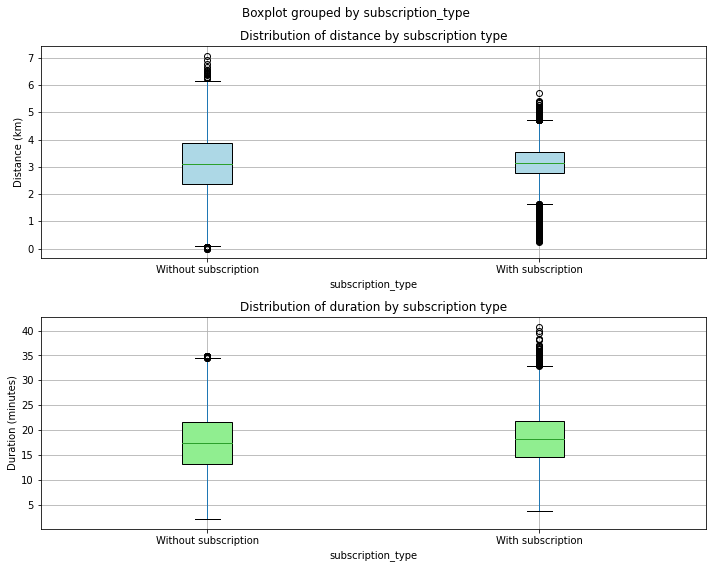

In [65]:
# Создаем два подграфика для расстояния и времени поездок
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# График для расстояния
boxplot_distance = final_data.boxplot(column='distance_km', by='subscription_type', ax=axes[0], patch_artist=True, boxprops=dict(facecolor='lightblue'))
axes[0].set_title('Distribution of distance by subscription type')
axes[0].set_ylabel('Distance (km)')
axes[0].set_xticklabels(['Without subscription', 'With subscription'])

# График для времени поездок
boxplot_duration = final_data.boxplot(column='duration', by='subscription_type', ax=axes[1], patch_artist=True, boxprops=dict(facecolor='lightgreen'))
axes[1].set_title('Distribution of duration by subscription type')
axes[1].set_ylabel('Duration (minutes)')
axes[1].set_xticklabels(['Without subscription', 'With subscription'])

# Регулируем расположение графиков
plt.tight_layout()

# Вывод графиков
plt.show()

Графики "Распределение расстояния по типу подписки" и "Распределение времени поездок по типу подписки" позволяют провести сравнительный анализ между пользователями с подпиской и без подписки в сервисе аренды самокатов GoFast.
Распределение расстояния по типу подписки:
Без подписки. Медианное расстояние составляет примерно 3.1, с интерквартильным размахом от 2.3 до 3.9. Усы ящика указывают на наличие множества выбросов, как в нижней, так и верхней части распределения, что свидетельствует о том, что часть пользователей без подписки совершают крайне короткие и долгие поездки.
С подпиской. Медианное расстояние равно примерно 3.2, с интерквартильным размахом от 2.8 до 3.7. Усы ящика также демонстрируют наличие выбросов как в нижней, так и верхней части распределения, подчеркивая разнообразие пройденных расстояний пользователями с подпиской.

Распределение времени поездок по типу подписки:
Без подписки. Медианное время поездок составляет примерно 17 минут, с интерквартильным размахом от 13.5 до 22. Усы ящика указывают на наличие выбросов в верхней части распределения, что может свидетельствовать о длительных поездках некоторых пользователей без подписки.
С подпиской. Медианное время поездок равно примерно 18.5 минут, с интерквартильным размахом от 15 до 23. Усы ящика также демонстрируют наличие выбросов в верхней части распределения, подчеркивая разнообразие времени поездок среди пользователей с подпиской.

Вывод: Оба вида пользователей, с подпиской и без подписки, проявляют разнообразие в дистанции и времени поездок. Подписка "ultra" несмотря на свои привилегии, не исключает наличие как крайне коротких, так и долгих поездок. Распределение данных подчеркивает важность адаптации сервиса под различные предпочтения пользователей для оптимизации их удовлетворения от использования GoFast.

### Вывод:
Объединив данные о пользователях, поездках и подписках в один датафрейм с использованием метода merge(), были созданы два отдельных датафрейма: с информацией о пользователях без подписки и пользователях с подпиской "ultra". Визуализация распределений расстояния и времени поездок позволила сравнить обе категории пользователей, выявив разнообразие пройденных дистанций и времени поездок. 

## Подсчёт выручки

### Создадим датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из предыдущего шага: найдем суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.

In [66]:
# Сгруппируем и сагрегируем данные по пользователям и месяцам, подсчитываем суммарное расстояние, количество поездок
#и суммарное время
aggregated_data = final_data.groupby(['user_id', 'month']).agg({
  'distance_km': 'sum',
   'duration': 'sum',
   'subscription_type': 'first'  # чтобы сохранить тип подписки пользователя
}).reset_index()

In [67]:
#Вывод первых строк агрегированного датафрейма для проверки
aggregated_data.head(15)

,user_id,month,distance_km,duration,subscription_type
0,1,1,7.03,41.42,ultra
1,1,4,0.75,6.23,ultra
2,1,8,6.72,44.78,ultra
3,1,10,5.81,31.58,ultra
4,1,11,7.00,53.40,ultra
5,1,12,6.75,27.20,ultra
6,2,3,10.19,60.96,ultra
7,2,4,6.17,39.05,ultra
8,2,6,3.26,13.85,ultra
9,2,7,6.78,46.17,ultra


In [68]:
# Добавим столбец с количеством поездок на основе 'distance_km'
aggregated_data['trips'] = (final_data['distance_km'] > 0).groupby([final_data['user_id'], final_data['month']]).sum().reset_index()['distance_km']

In [69]:
#Вывод первых строк агрегированного датафрейма для проверки
aggregated_data.head(15)

,user_id,month,distance_km,duration,subscription_type,trips
0,1,1,7.03,41.42,ultra,2
1,1,4,0.75,6.23,ultra,1
2,1,8,6.72,44.78,ultra,2
3,1,10,5.81,31.58,ultra,2
4,1,11,7.00,53.40,ultra,3
5,1,12,6.75,27.20,ultra,2
6,2,3,10.19,60.96,ultra,3
7,2,4,6.17,39.05,ultra,2
8,2,6,3.26,13.85,ultra,1
9,2,7,6.78,46.17,ultra,2


### В полученный датафрейм добавим столбец с помесячной выручкой, которую принёс каждый пользователь. 

In [70]:
import numpy as np
# Округлим значения продолжительности в aggregated_data до ближайшего целого числа
aggregated_data['duration'] = np.ceil(aggregated_data['duration'])

In [71]:
# Проверим результат
aggregated_data.head()

,user_id,month,distance_km,duration,subscription_type,trips
0,1,1,7.03,42.0,ultra,2
1,1,4,0.75,7.0,ultra,1
2,1,8,6.72,45.0,ultra,2
3,1,10,5.81,32.0,ultra,2
4,1,11,7.00,54.0,ultra,3


In [72]:
# Создаем столбец 'monthly_revenue', содержащий выручку для каждой поездки
aggregated_data['monthly_revenue'] = 0  # инициализируем столбец нулями

In [73]:
# Заполняем столбец 'monthly_revenue' в зависимости от типа подписки
aggregated_data.loc[aggregated_data['subscription_type'] == 'free', 'monthly_revenue'] = (
    8 * aggregated_data['duration'] + 50 * aggregated_data['trips']
)

aggregated_data.loc[aggregated_data['subscription_type'] == 'ultra', 'monthly_revenue'] = (
    199 + 6 * aggregated_data['duration']
)

In [74]:
aggregated_data.head(15)

,user_id,month,distance_km,duration,subscription_type,trips,monthly_revenue
0,1,1,7.03,42.0,ultra,2,451.0
1,1,4,0.75,7.0,ultra,1,241.0
2,1,8,6.72,45.0,ultra,2,469.0
3,1,10,5.81,32.0,ultra,2,391.0
4,1,11,7.00,54.0,ultra,3,523.0
5,1,12,6.75,28.0,ultra,2,367.0
6,2,3,10.19,61.0,ultra,3,565.0
7,2,4,6.17,40.0,ultra,2,439.0
8,2,6,3.26,14.0,ultra,1,283.0
9,2,7,6.78,47.0,ultra,2,481.0


In [75]:
aggregated_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11300 entries, 0 to 11299
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   user_id            11300 non-null  int64  
 1   month              11300 non-null  int64  
 2   distance_km        11300 non-null  float64
 3   duration           11300 non-null  float64
 4   subscription_type  11300 non-null  object 
 5   trips              11300 non-null  int64  
 6   monthly_revenue    11300 non-null  float64
dtypes: float64(3), int64(3), object(1)
memory usage: 618.1+ KB


### Вывод:
На шаге 5 был создан датафрейм с агрегированными данными о поездках, основанный на объединенных данных из шага 4. Добавлены суммарные значения расстояния, количества поездок и времени для каждого пользователя за каждый месяц. Также в датафрейм добавлен столбец с помесячной выручкой для каждого пользователя, учитывая условия оплаты для подписчиков и тех, у кого нет подписки. 

## Проверка гипотез

### Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверим гипотезу.

Для проверки гипотезы о том, тратят ли пользователи с подпиской больше времени на поездки, можно воспользоваться статистическим анализом - t-тестом. В данном случае, сравним средние продолжительности поездок для пользователей с подпиской и без подписки.
За нулевую гипотезу примем что они равны, альтернативная - с подпиской тратят больше времени на поездку

In [76]:
from scipy import stats as st

In [77]:
# Разделим данные на две выборки: с подпиской и без подписки
duration_subscription = final_data[final_data['subscription_type'] == 'ultra']['duration']
duration_no_subscription = final_data[final_data['subscription_type'] == 'free']['duration']

In [78]:
alpha = 0.05 # уровень статистической значимости

In [79]:
results = st.ttest_ind(duration_subscription, duration_no_subscription, alternative='greater')

In [80]:
print('p-значение:', results.pvalue)

p-значение: 4.68327274119323e-28


In [81]:
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

Отвергаем нулевую гипотезу


Полученное значение p-value меньше заданного уровня значимости, поэтому можно отвергнуть нулевую гипотезу. Есть основания говорить, что пользователи с подпиской тратят больше времени на поездки.

### Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? Проверим гипотезу 

В этом случае, нулевая гипотеза Ho: m <= 3130 m (среднее расстояние не превышает 3130 метров).
Альтернативная гипотеза H1: m> 3130 (среднее расстояние превышает 3130 метров).

In [82]:
interested_value = 3.130
alpha = 0.05 # уровень статистической значимости

In [83]:
# Получим выборку с подпиской
distance_subscription = final_data[final_data['subscription_type'] == 'ultra']['distance_km']

In [84]:
results = st.ttest_1samp(
    distance_subscription, 
    interested_value)

In [85]:
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.1601562785135761
Не получилось отвергнуть нулевую гипотезу


Полученное значение p-value равно 0.1601562785135761, что больше уровня статистической значимости alpha = 0.05. Поэтому мы не можем отвергнуть нулевую гипотезу. В данном контексте это означает, что нет достаточных статистических доказательств для того, чтобы утверждать, что среднее расстояние за одну поездку с подпиской "ultra" превышает 3130 метров.

Проверим теперь в MEТРАХ
В этом случае, нулевая гипотеза Ho: m <= 3130 m (среднее расстояние не превышает 3130 метров). Альтернативная гипотеза H1: m> 3130 (среднее расстояние превышает 3130 метров).

In [86]:
interested_value = 3130
alpha = 0.05 # уровень статистической значимости

In [87]:
# Получим выборку с подпиской
distance_subscription = final_data[final_data['subscription_type'] == 'ultra']['distance']

In [88]:
results = st.ttest_1samp(
    distance_subscription, 
    interested_value)

In [89]:
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.16092623043004292
Не получилось отвергнуть нулевую гипотезу


###  Проверим гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. 

Для проверки гипотезы о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки, можно воспользоваться статистическим анализом - t-тестом. В данном случае, сравним выручки по месяцам для пользователей с подпиской и без.
За нулевую гипотезу примем, что они равны, альтернативная - с подпиской выручка больше, чем без подписки

In [90]:
# Разделим данные на две группы: пользователи с подпиской и без подписки
df_subscription = aggregated_data[aggregated_data['subscription_type'] == 'ultra']
df_no_subscription = aggregated_data[aggregated_data['subscription_type'] == 'free']

In [91]:
df_subscription

,user_id,month,distance_km,duration,subscription_type,trips,monthly_revenue
0,1,1,7.03,42.0,ultra,2,451.0
1,1,4,0.75,7.0,ultra,1,241.0
2,1,8,6.72,45.0,ultra,2,469.0
3,1,10,5.81,32.0,ultra,2,391.0
4,1,11,7.00,54.0,ultra,3,523.0
...,...,...,...,...,...,...,...
4528,699,6,4.07,17.0,ultra,1,301.0
4529,699,8,7.02,45.0,ultra,2,469.0
4530,699,9,6.37,31.0,ultra,2,385.0
4531,699,10,4.71,16.0,ultra,1,295.0


In [92]:
df_no_subscription

,user_id,month,distance_km,duration,subscription_type,trips,monthly_revenue
4533,700,1,2.52,15.0,free,1,170.0
4534,700,2,13.45,86.0,free,5,938.0
4535,700,3,3.80,19.0,free,1,202.0
4536,700,4,2.98,16.0,free,1,178.0
4537,700,6,5.93,29.0,free,2,332.0
...,...,...,...,...,...,...,...
11295,1534,6,3.41,25.0,free,2,300.0
11296,1534,8,7.62,48.0,free,2,484.0
11297,1534,9,4.93,23.0,free,1,234.0
11298,1534,11,13.35,77.0,free,4,816.0


In [93]:
# Выполним t-тест для сравнения выручки между двумя группами
results = st.ttest_ind(df_subscription['monthly_revenue'], df_no_subscription['monthly_revenue'], alternative='greater', equal_var=False)

In [94]:
# Определим уровень значимости
alpha = 0.05
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу.  Существуют статистически значимые различия в выручке.')
else:
    print('Не отвергаем нулевую гипотезу. Статистически значимых различий в выручке нет или выручка от пользователей с подпиской не меньше выручки от пользователей без подписки.') 

p-значение: 3.740263628220316e-43
Отвергаем нулевую гипотезу.  Существуют статистически значимые различия в выручке.


В данном случае, мы используем alternative='greater', чтобы указать, что интересует нас направление "больше". Полученное p-значение (1.257780646441438e-45) говорит о том, что мы отвергаем нулевую гипотезу о равенстве выручки от пользователей с подпиской и без подписки в пользу альтернативной гипотезы, что выручка от пользователей с подпиской по месяцам статистически значимо выше, чем у пользователей без подписки.
Таким образом, можно сделать вывод о том, что существуют статистически значимые различия в выручке от пользователей с подпиской и без подписки, причем выручка от пользователей с подпиской статистически значимо выше.

### Представим такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест  понадобился бы для проверки этой гипотезы?

Для проверки гипотезы о том, что обновление серверов снизило количество обращений в техподдержку, можно использовать статистический тест для сравнения средних двух групп до и после обновления - t-тест для связанных выборок.
Нулевая гипотеза (H0) может быть сформулирована следующим образом:среднее количество обращений до обновления и после равны m1=m2
Альтернативная гипотеза (H1) будет утверждать, что количество обращений снизилось: m1>m2

### Вывод:
Анализ проведенных гипотез позволяет сделать следующие выводы:1)Пользователи с подпиской проводят больше времени на поездках по сравнению с теми, у кого подписки нет. 2) Среднее расстояние за одну поездку у пользователей с подпиской "ultra" не превышает 3130 метров. 3) Месячная выручка от пользователей с подпиской статистически значимо выше, чем у пользователей без подписки. 4) Для проверки гипотезы о снижении обращений в техподдержку после обновления серверов предлагается использовать t-тест для связанных выборок.

## Распределения

###  Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Выясним, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подберем параметры распределения, описывающего эту ситуацию, построим график распределения и дадим ответ на вопрос о количестве промокодов.

In [95]:
# Заданные параметры
p_success = 0.1  # Вероятность продления подписки после использования промокода
target_probability = 0.05  # Вероятность не выполнения плана

In [96]:
# Подберем значение n с шагом = 1
n_values = np.arange(1, 5000)
probabilities = binom.cdf(99, n_values, p_success)  # используем функцию распределения

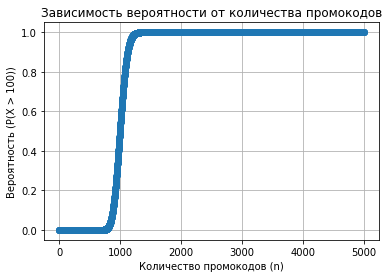

In [97]:
# Построим график
plt.plot(n_values, 1 - probabilities, marker='o')  # используем 1 - P(X < 100) для вероятности P(X > 100)
plt.xlabel('Количество промокодов (n)')
plt.ylabel('Вероятность (P(X > 100))')
plt.title('Зависимость вероятности от количества промокодов')
plt.grid(True)
plt.show()

In [98]:
# Определим минимальное значение n, при котором вероятность не выполнения плана составляет примерно 0.05
min_n_index = np.argmax(1 - probabilities > target_probability)
min_n = n_values[min_n_index]

In [99]:
min_n 

850

In [100]:
# Код ревьюера
probabilities[0]

1.0

Таким образом, для выполнения плана, который состоит в том, чтобы как минимум 100 существующих клиентов продлили подписку после использования промокодов, необходимо разослать примерно 850 промокодов на бесплатный месяц подписки. Вероятность того, что при таком количестве промокодов более 100 пользователей продлят подписку, составляет примерно 5%.

### Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации построим примерный график распределения и оценим вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

In [101]:
# Вероятность открытия уведомления
p = 0.40

In [102]:
# Общее количество уведомлений
n = 1000000

In [103]:
# Параметры нормального распределения
mu = n * p
sigma = sqrt(n * p * (1 - p))
distr = st.norm(mu,sigma)

In [104]:
#cчитаем вероятность хвоста слева от 399 500
result = distr.cdf(399500)

In [105]:
result

0.15371708296369768

Таким образом, результат 0.1537 указывает на то, что вероятность того, что уведомление откроют не более 399,5 тыс. пользователей, составляет примерно 15.37%, что означает, что большинство пользователей не откроют уведомление.

Для выполнения плана и обеспечения продления подписки как минимум 100 клиентами, необходимо разослать примерно 850 промокодов. Это обеспечит вероятность более 5% того, что более 100 пользователей воспользуются промокодами. В случае рассылки 1 млн уведомлений о push-уведомлениях, вероятность того, что не более 399,5 тыс. пользователей откроют уведомление, составляет примерно 15.37%. Это говорит о том, что большинство пользователей не будет открывать уведомления.

## Вывод
В данной аналитической работе проведен полный цикл анализа данных для сервиса аренды самокатов GoFast. Выполнены задачи по загрузке, предобработке и исследовательскому анализу данных. Объединены данные о пользователях, поездках и подписках, а также подсчитана выручка. Проверены гипотезы о поведении пользователей с подпиской и без, а также проведена аналитика распределения для акций.
Анализ гипотез позволил сделать следующие выводы и рекомендации для бизнеса.Пользователи с подпиской активнее пользуются сервисом, проводя больше времени на поездках. Это предоставляет потенциал для более эффективного маркетинга и удержания подписчиков.Среднее расстояние за поездку у пользователей с подпиской "ultra" не превышает 3130 метров, что соответствует оптимальным параметрам. Это подтверждает привлекательность данной подписки для пользователей.
Статистически значимое увеличение месячной выручки от пользователей с подпиской подчеркивает их важность для финансового успеха компании. Для успешной акции по продлению подписок рекомендуется разослать примерно 850 промокодов, обеспечивая вероятность более 5% успешных продлений. При рассылке 1 млн push-уведомлений ожидается, что менее 399,5 тыс. пользователей откроют уведомление. Рекомендуется пересмотреть стратегию рассылок для повышения их эффективности.